# Кластеризация. Метод K-Means. Домашнее задание

## Задача

Пусть имеется набор данных `Mall_Customers.csv` о покупателях супермаркета:

* CustomerID — идентификатор покупателя;
* Genre — пол;
* Age — возраст;
* Annual Income (k$) — годовой доход покупателя в тыс. долл.;
* Spending Score (1–100) — рейтинг трат покупателя.

Решите задачу кластеризации покупателей, чтобы в дальнейшем планировать маркетинговые акции для каждой группы.

### Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других обнаруженных свойствах данных.

In [361]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import io
from pathlib import Path
from pandas import option_context

In [53]:
dataset1_filename = './Mall_Customers.csv'
df1 = pd.read_csv(dataset1_filename)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [54]:
# И поменяем названия колонок на более короткие. Для удобства.
df1.rename(columns={'Annual Income (k$)':'Income','Spending Score (1-100)': 'Score'}, inplace=True)
df1.columns

Index(['CustomerID', 'Genre', 'Age', 'Income', 'Score'], dtype='object')

### Задание 2

Метод k-средних требует явно задать количество кластеров, на которые будут разбиваться данные. Поскольку данных может быть настолько много, что построение одной модели будет занимать несколько часов, важно примерно оценить количество кластеров до запуска обучения модели.

На основе результатов разведочного анализа данных предположите, какое количество кластеров будет оптимальным, и аргументируйте предположение.

In [55]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
def unload_dataset_info(df:pd.DataFrame, dataset_file_name:str)->pd.DataFrame:
    info_filename = f'./{Path(dataset_file_name).stem}_info.xlsx'
    buf = io.StringIO()
    df.info(buf=buf)
    s = buf.getvalue()
    columns = s.splitlines()[3].split()
    lines =   [line.split() for line in s.splitlines()[5:-2]]
    lines = [[' '.join(row[1:-3]), row[-3], row[-2], row[-1]   ] for row in lines]
    df_info = pd.merge(
        pd.DataFrame(lines, columns=columns[1:])
        , df.nunique().to_frame(name='Nu'), 
        left_on='Column', 
        right_index=True)# .set_index(['#']).reset_index()
    df_vc = pd.DataFrame([[col, sorted(df[col].value_counts().to_dict().items(), key=lambda x: x[0])] for col in df.columns if len(df[col].value_counts()) < 21], columns=['Column', 'vc'])
    df_info = pd.merge(df_info, df_vc, how='left', on='Column')
    df_info = pd.merge(df_info, df.describe().T, how='left', left_on='Column', right_index=True)
    df_info = df_info[['Column', 'Non-Null']].copy()\
        .join(pd.DataFrame(df.isna().sum()).rename(columns={0: 'Null_cnt'}), how='left', on='Column')\
        .join(pd.DataFrame(df.isna().sum() / df.shape[0]).round(3).rename(columns={0: 'Null_percent'}), how='left', on='Column')\
        .join(df_info.set_index('Column').drop(columns=['Non-Null', 'Count'] ), how='left', on='Column')
    if not Path(info_filename).exists():
        df_info.to_excel(info_filename, index=False)
    return df_info

In [56]:
display(unload_dataset_info(df1, dataset1_filename))

Column Non-Null  Null_cnt  Null_percent  ...    25%    50%     75%    max
0  CustomerID      200         0           0.0  ...  50.75  100.5  150.25  200.0
1       Genre      200         0           0.0  ...    NaN    NaN     NaN    NaN
2         Age      200         0           0.0  ...  28.75   36.0   49.00   70.0
3      Income      200         0           0.0  ...  41.50   61.5   78.00  137.0
4       Score      200         0           0.0  ...  34.75   50.0   73.00   99.0

[5 rows x 15 columns]

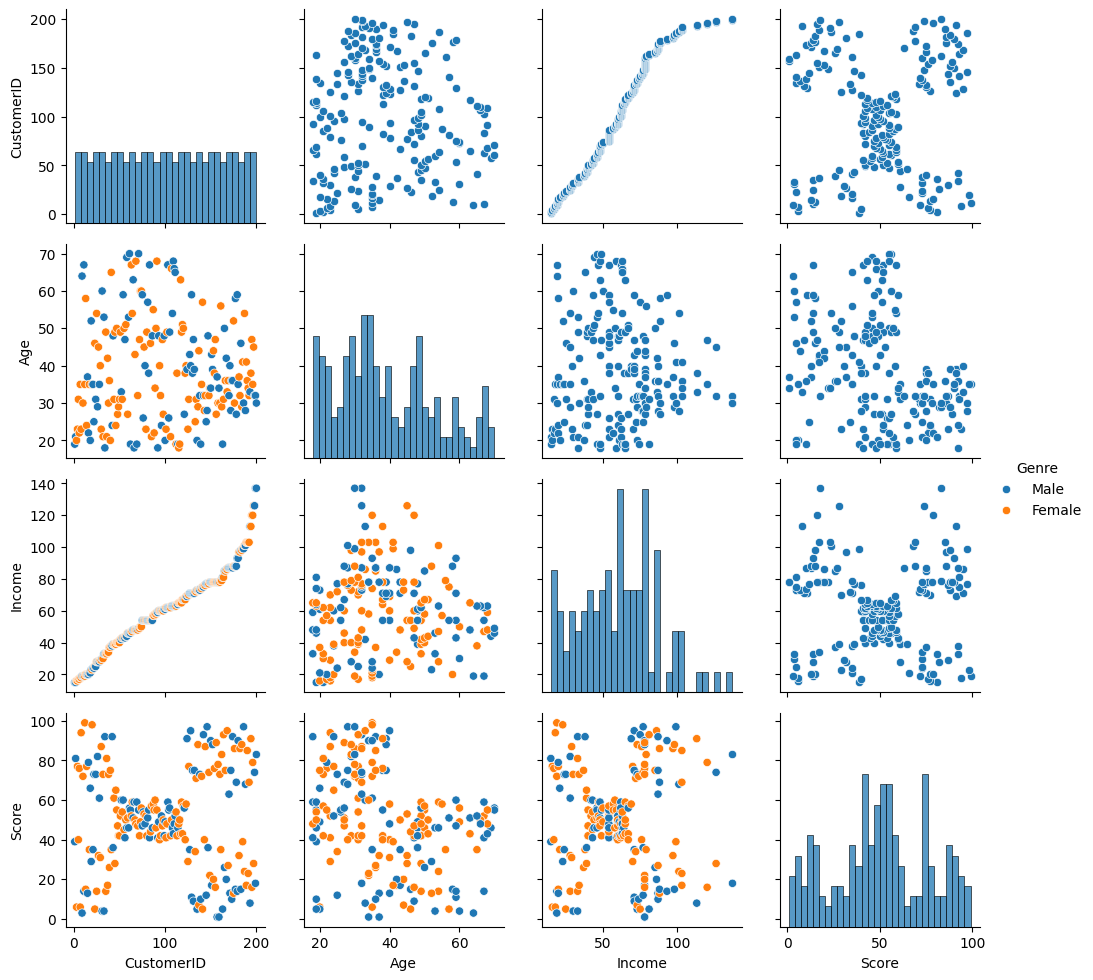

In [57]:
# Отобразим парную диаграмму числовых признаков, включая целевую переменную.
# sns.pairplot(df_tmp[number_features + [target_name]]);
g1 = sns.PairGrid(df1, hue='Genre', height = 2.5)
g1.map_diag(sns.histplot, bins=30, hue=None)
g1.map_lower(sns.scatterplot)
g1.map_upper(sns.scatterplot, hue=None)
g1.add_legend();

In [58]:
df1.CustomerID.value_counts().sort_values(ascending=False)

CustomerID
1      1
12     1
24     1
3      1
4      1
      ..
195    1
196    1
197    1
198    1
200    1
Name: count, Length: 200, dtype: int64

In [59]:
# Наблюдаем, что признак CustomerId почему, то каким то странным образом коррелирует с признаком Income
# Признак CustomerID не имеет дубликатов.
# Скорее всего обозначает идентификатор некоего субъекта наблюдений.
# Есть смысл удалить признак из датасета. Потерь информации не ожидается.
df1.drop(columns=['CustomerID'], inplace=True)

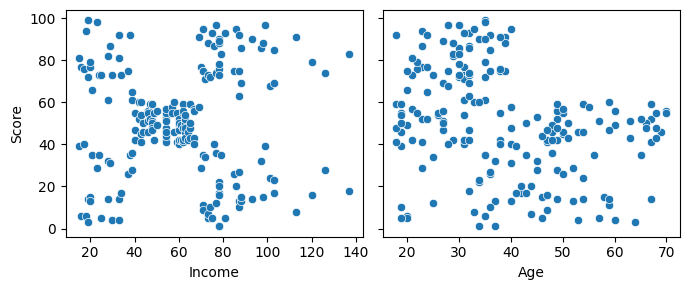

In [60]:
# На парной диаграмме признаков Income, Score можем наблюдать 5 кластеров
# На парной диаграмме признаков Age, Score можем наблюдать 2 кластера.
# Отобразим обе диаграммы отдельно.
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
# fig.suptitle('Распределение целевой переменной')
sns.scatterplot(ax=axs[0], data=df1, x='Income', y='Score')
sns.scatterplot(ax=axs[1], data=df1, x='Age', y='Score')

# plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.tight_layout()

Можно попробовать построить две модели, на 2 и на 5 кластеров.

### Задание 3

Преобразуйте категориальный признак Genre в численный.

In [61]:
df1.Genre.value_counts()

Genre
Female    112
Male       88
Name: count, dtype: int64

In [62]:
df1.replace({'Genre':{'Male':0, 'Female':1}},inplace=True)
df1.Genre.value_counts()

C:\Users\Alex\AppData\Local\Temp\ipykernel_19752\3741322700.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1.replace({'Genre':{'Male':0, 'Female':1}},inplace=True)


Genre
1    112
0     88
Name: count, dtype: int64

In [63]:
# Т.к. модель кластеризации работает на основании расчета расстояний, целесобрзано выполнить масштабирование признаков.
# Выбросов нет, можно применить стандартизацию.
from sklearn.preprocessing import StandardScaler

In [64]:
df1_scaler = StandardScaler()

In [65]:
X1_scaled = df1_scaler.fit_transform(df1)
pd.DataFrame(X1_scaled, columns=df1.columns, index=df1.index).describe()

Genre           Age        Income         Score
count  2.000000e+02  2.000000e+02  2.000000e+02  2.000000e+02
mean  -7.549517e-17 -1.021405e-16 -2.131628e-16 -1.465494e-16
std    1.002509e+00  1.002509e+00  1.002509e+00  1.002509e+00
min   -1.128152e+00 -1.496335e+00 -1.738999e+00 -1.910021e+00
25%   -1.128152e+00 -7.248436e-01 -7.275093e-01 -5.997931e-01
50%    8.864053e-01 -2.045351e-01  3.587926e-02 -7.764312e-03
75%    8.864053e-01  7.284319e-01  6.656748e-01  8.851316e-01
max    8.864053e-01  2.235532e+00  2.917671e+00  1.894492e+00

### Задание 4

Постройте модель кластеризации с помощью метода k-средних. Определите оптимальное количество кластеров с помощью метода локтя.

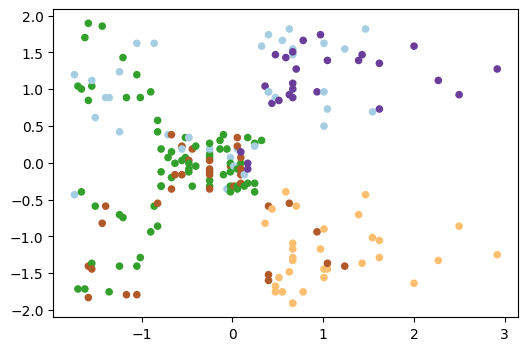

In [145]:
model_knn_five_clusters = KMeans(n_clusters=5, random_state=40)
df1_five_clusters = model_knn_five_clusters.fit_predict(X1_scaled)
plt.figure(figsize=(6, 4))
plt.scatter(X1_scaled[: ,2], X1_scaled[: ,3], s=20, c=df1_five_clusters, cmap='Paired');
# Отображать центры кластеров здесь нельзя, т.к. центроиды в заданы в 4-х мерной системе координат, а диаграмма рассеяния в двухмерной системе.
# plt.scatter(model_knn_five_clusters.cluster_centers_[:, 0], model_knn_five_clusters.cluster_centers_[:, 1], s=80, c = 'red', marker = '^', label = 'Centroids');


# Не очень хороший результат, точки на графиках разделились, не так как мы бы ожидали.
# Центры кластеров, сформировались не совсем так, как хотелось бы.
# К сожалению, гиперпараметры не позволяют как то повлиять на модель

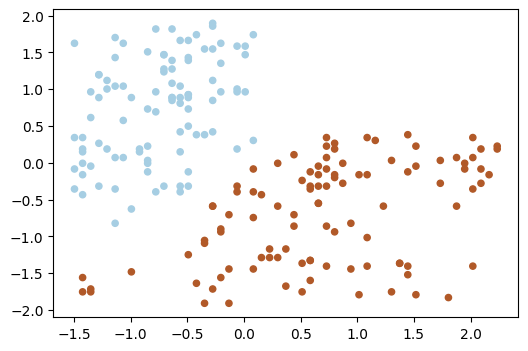

In [146]:
model_knn_two_clusters = KMeans(n_clusters=2, random_state=40)
df1_two_clusters = model_knn_two_clusters.fit_predict(X1_scaled)
plt.figure(figsize=(6, 4))
plt.scatter(X1_scaled[: ,1], X1_scaled[: ,3], s=20, c=df1_two_clusters, cmap='Paired');
# Отображать центры кластеров здесь нельзя, т.к. центроиды в заданы в 4-х мерной системе координат, а диаграмма рассеяния в двухмерной системе.
# # plt.scatter(model_knn_two_clusters.cluster_centers_[:, 0], model_knn_two_clusters.cluster_centers_[:, 1], s=80, c = 'red', marker = '^', label = 'Centroids');

# Очень хороший результат, отличное разделение на два кластера, как и было предсказано по диаграмме

C:\Users\Alex\AppData\Local\Temp\ipykernel_19752\848396650.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = X1_pca2.iloc[:,0], y = X1_pca2.iloc[:,1], palette="flare", s=60)


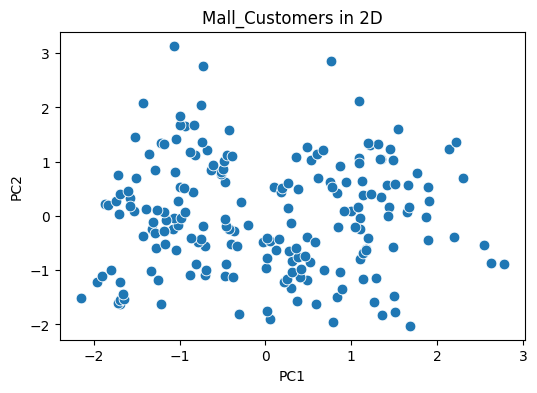

In [149]:
# Нужно сказать, что мы отображали на диаграммах рассеяния только два признака. На самом деле в модели больше  признаков.
# Чтобы отобразить их все, нужно снизить размерность и отобразить на диаграмме рассеяния все признаки, тогда количество кластеров может быть иным.
pca_2 = PCA(n_components=2, random_state=42)
pca_2.fit(X1_scaled)
X1_pca2 = pd.DataFrame(pca_2.transform(X1_scaled), columns=['PCA1','PCA2'])
plt.figure(figsize=(6, 4))
sns.scatterplot(x = X1_pca2.iloc[:,0], y = X1_pca2.iloc[:,1], palette="flare", s=60)
plt.title('Mall_Customers in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Не добавилось понимания сколько кластеров можно выделить. Какого то явного разделения не наблюдается. 

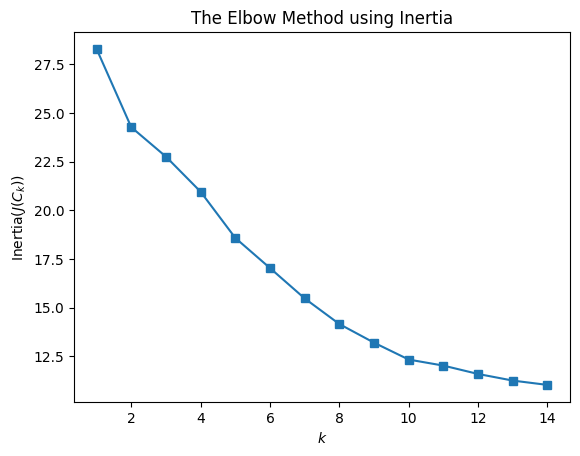

In [175]:
inertias = []
distortions = []
max_clusters = 15

for k in range(1, max_clusters):
    model_kmeans = KMeans(n_clusters=k, random_state=40, n_init='auto').fit(X1_scaled)
    inertias.append(np.sqrt(model_kmeans.inertia_))
    # distortions.append(sum(np.min(cdist(X, model_kmeans.cluster_centers_,
    #                                     'euclidean'), axis=1)) / X.shape[0])

plt.plot(range(1, max_clusters), inertias, marker="s")
plt.title('The Elbow Method using Inertia')
plt.xlabel("$k$")
plt.ylabel("Inertia($J(C_k)$)");

# Можно выделить 2 перелома на 2 и 10 кластеров. Гипотеза о двух кластерах уже нашла подтверждение, построим модель на 10 кластеров.
# В целом какого то явного "перелома" на графике  не наблюдается.


### Задание 5

Постройте финальную модель кластеризации с количеством кластеров, опредёленным в предыдущем задании.

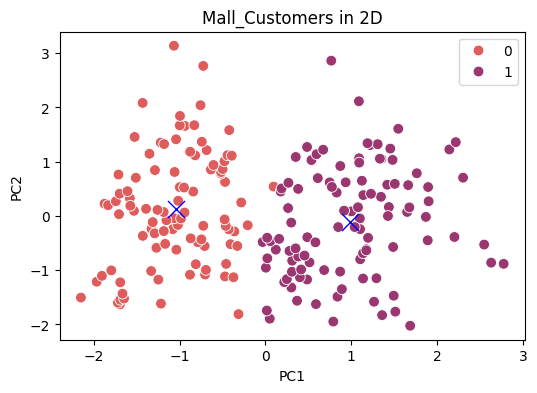

In [178]:
# Отобразим 2 кластера на признаковом пространстве сжатом до 2-х прзинакоа метдом PCA
# Модель сжатия уже была предобучена
df1_two_centroids_pca = pca_2.transform(model_knn_two_clusters.cluster_centers_)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X1_pca2.iloc[:,0], y=X1_pca2.iloc[:,1], hue=df1_two_clusters,  palette="flare", s=60)
sns.scatterplot(x=df1_two_centroids_pca[:, 0], y=df1_two_centroids_pca[:, 1], marker="x", s=150, color = 'blue')
plt.title('Mall_Customers in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Наблюаем два кластера и центроиди в центре кластеров.

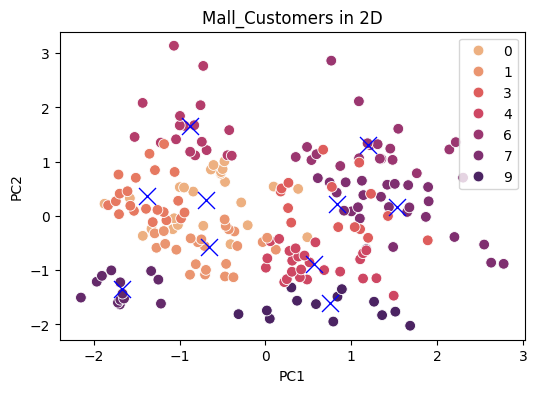

In [179]:
# Отобразим 10 кластеров на признаковом пространстве сжатом до 2-х прзинакоа метдом PCA
# Модель сжатия уже была предобучена
model_knn_ten_clusters = KMeans(n_clusters=10, random_state=40)
df1_ten_clusters = model_knn_ten_clusters.fit_predict(X1_scaled)
df1_ten_centroids_pca = pca_2.transform(model_knn_ten_clusters.cluster_centers_)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X1_pca2.iloc[:,0], y=X1_pca2.iloc[:,1], hue=df1_ten_clusters,  palette="flare", s=60)
sns.scatterplot(x=df1_ten_centroids_pca[:, 0], y=df1_ten_centroids_pca[:, 1], marker="x", s=150, color = 'blue')
plt.title('Mall_Customers in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Наблюдаем не очень явно 10 кластеров и центроиды, примерно в центре кластеров.

# Кластеризация. DBSCAN

Имеется некоторый набор данных `gt_2015.csv` о производительности и других параметрах ветряных электростанций:
* AT — температура окружающей среды.
* PT — давление окружающей среды.
* AH — влажность окружающей среды.
* AFDP — перепад давления на воздушном фильтре.
* GTEP — давление на выходе из газовой турбины.
* TIT — температура на входе в турбину.
* TAT — температура на выходе из турбины.
* TEY — энергоотдача турбины.
* CDP — давление нагнетания компрессора.
* CO — выбросы угарного газа.
* NOX — выбросы оксидов азота.

Решите задачу кластеризации электростанций для дальнейшего совместного управления схожими электростанциями.

# Задание 1

Загрузите датасет и выполните разведочный анализ данных. Сделайте выводы о найденных закономерностях, особенностях и других свойствах данных, которые вы обнаружите.

In [181]:
dataset_filename = './gt_2015.csv'
df = pd.read_csv(dataset_filename)

# Задание 2

Предположите по результатам разведочного анализа данных, какие группы электростанций существуют, чем они отличаются, каково их количество.

In [182]:
df.head()

AT      AP      AH    AFDP  ...     TEY     CDP      CO      NOX
0  1.95320  1020.1  84.985  2.5304  ...  116.27  10.799  7.4491  113.250
1  1.21910  1020.1  87.523  2.3937  ...  109.18  10.347  6.4684  112.020
2  0.94915  1022.2  78.335  2.7789  ...  125.88  11.256  3.6335   88.147
3  1.00750  1021.7  76.942  2.8170  ...  132.21  11.702  3.1972   87.078
4  1.28580  1021.6  76.732  2.8377  ...  133.58  11.737  2.3833   82.515

[5 rows x 11 columns]

In [183]:
# Сгруппируем основную информацию о датасете и выгрузим в excel.
# import io
display(unload_dataset_info(df, dataset_filename))

# Все признаки числовые

Column Non-Null  Null_cnt  ...        50%          75%        max
0      AT     7384         0  ...    17.4565    23.684750    37.1030
1      AP     7384         0  ...  1014.0000  1018.300000  1036.6000
2      AH     7384         0  ...    70.9520    79.653750    96.6660
3    AFDP     7384         0  ...     3.5385     4.194825     5.2395
4    GTEP     7384         0  ...    25.3310    30.018250    40.7160
5     TIT     7384         0  ...  1080.3000  1099.900000  1100.4000
6     TAT     7384         0  ...   549.7200   550.030000   550.5900
7     TEY     7384         0  ...   131.6000   147.160000   179.5000
8     CDP     7384         0  ...    11.9330    13.148000    15.1590
9      CO     7384         0  ...     2.5334     3.702550    41.0970
10    NOX     7384         0  ...    56.8385    65.093250   119.6800

[11 rows x 15 columns]

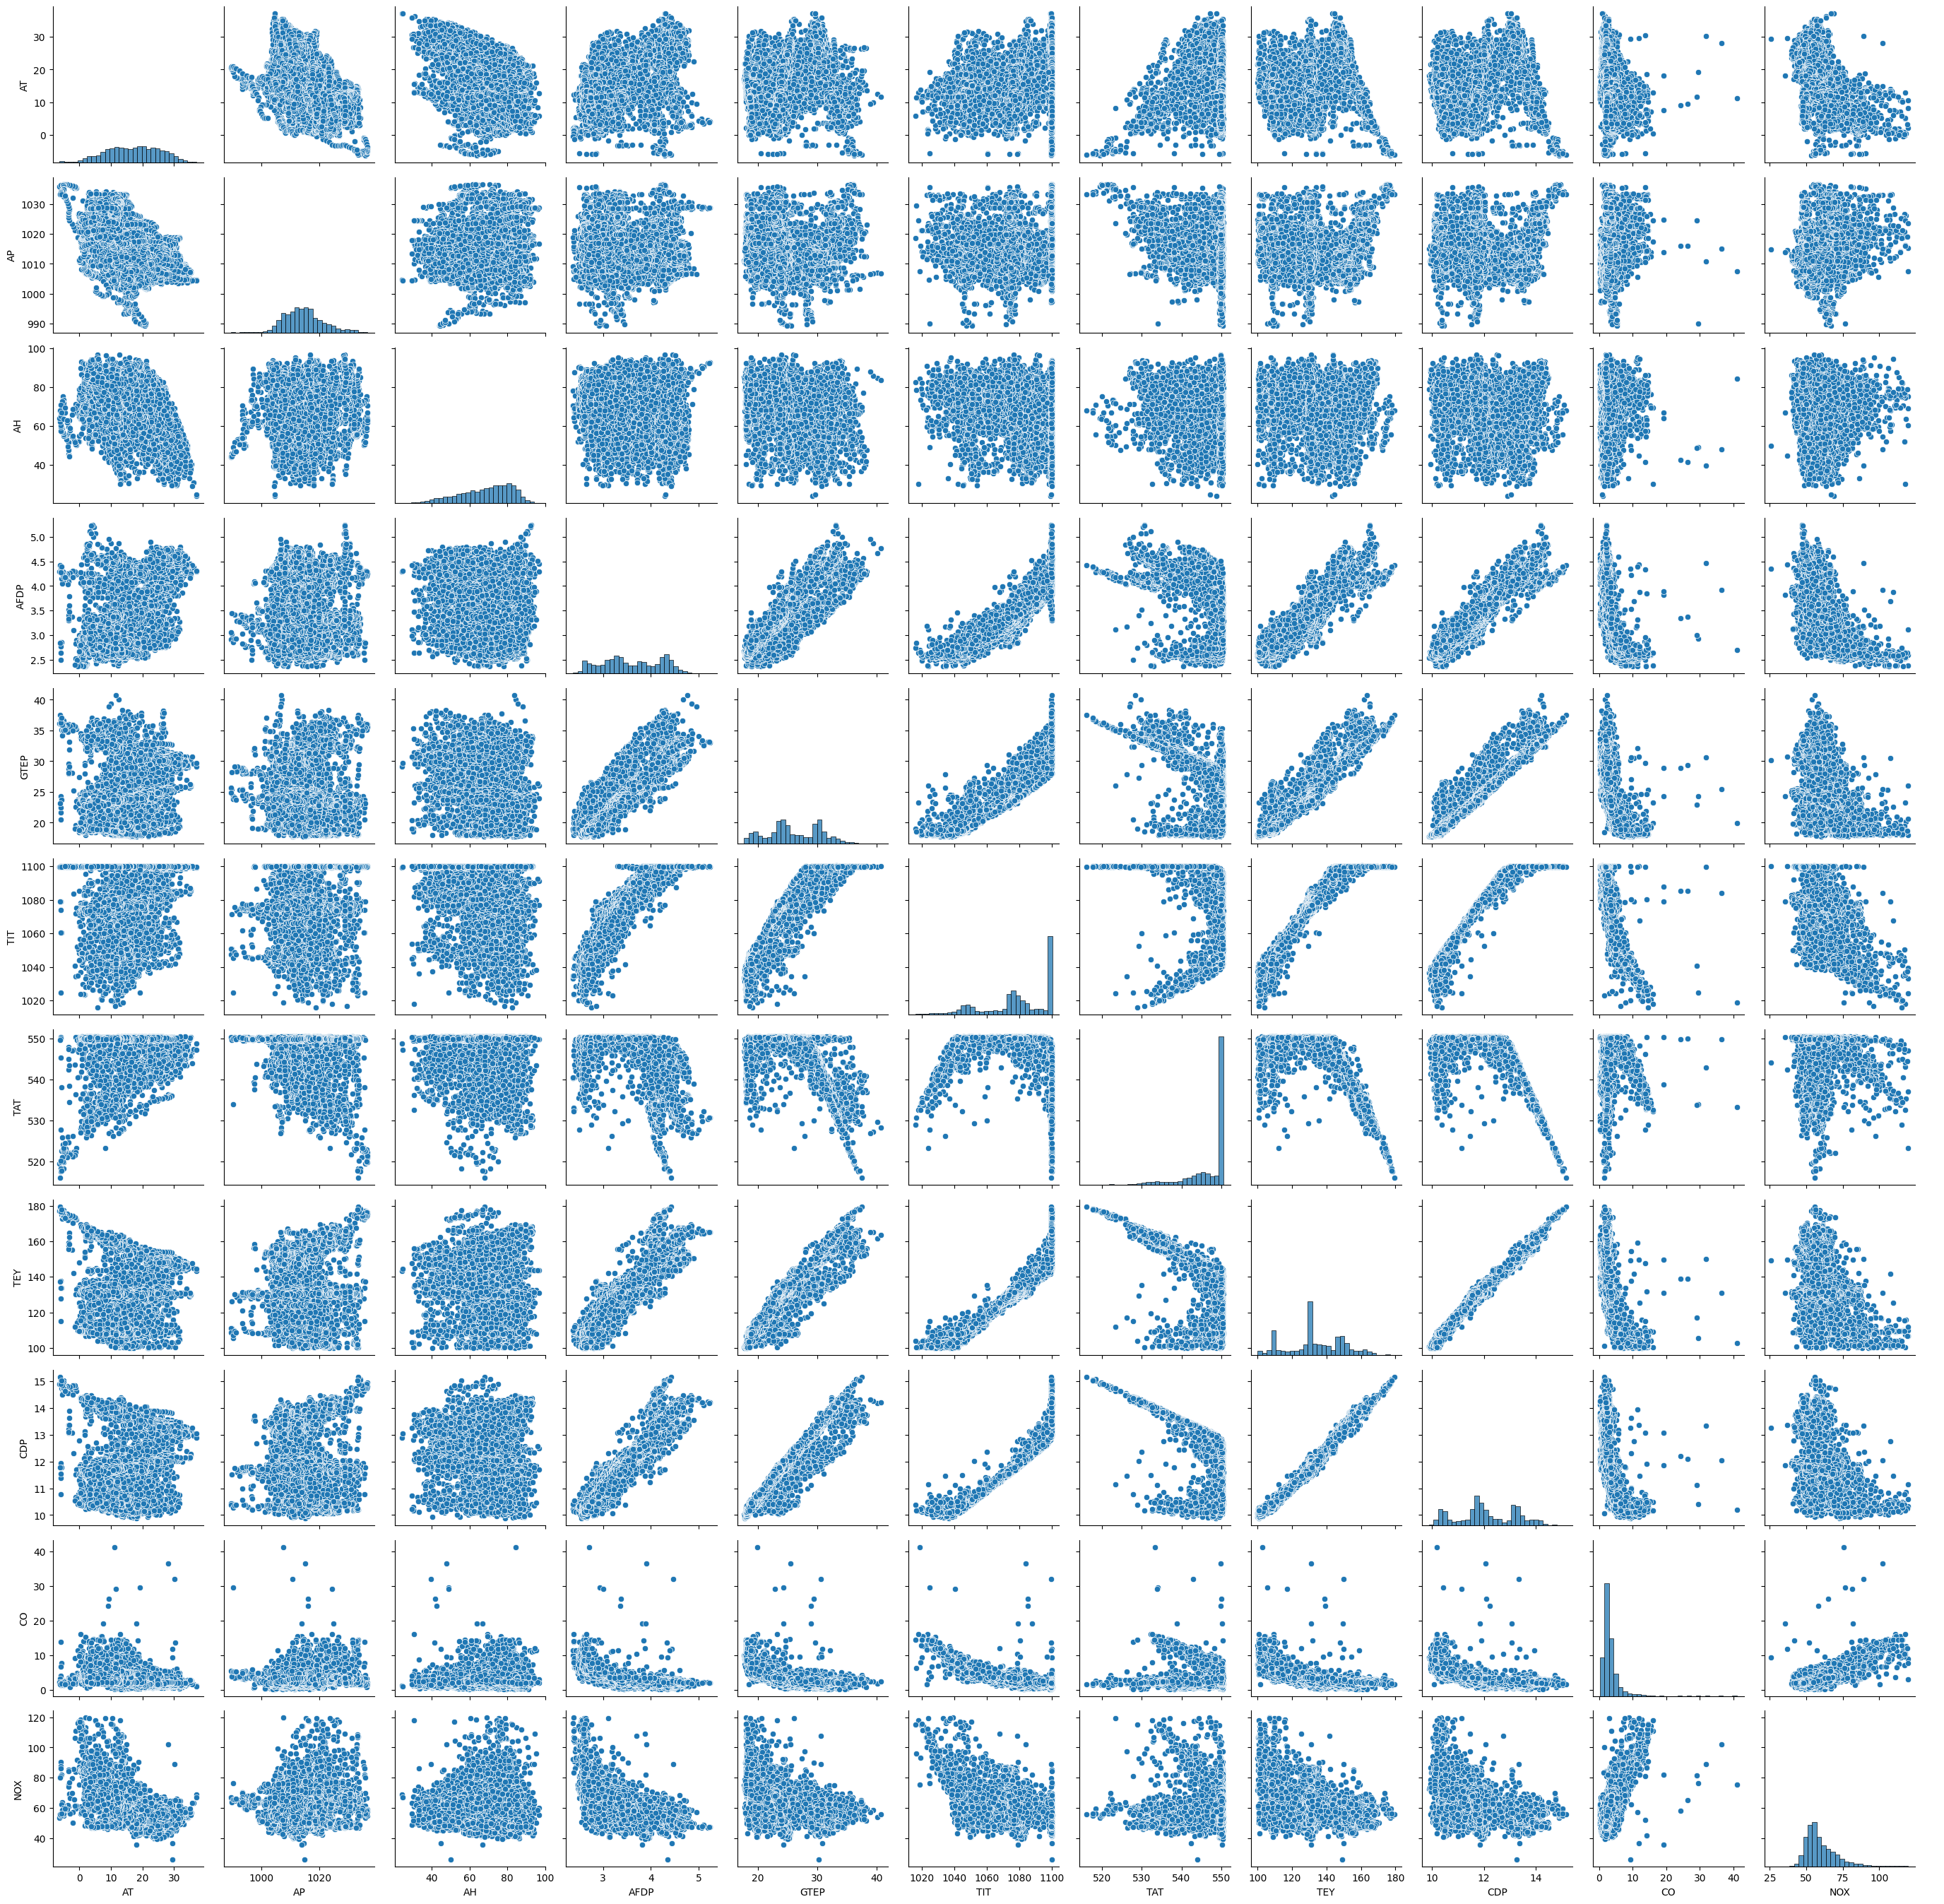

In [184]:
g1 = sns.PairGrid(df, height = 2.5)
g1.map_diag(sns.histplot, bins=30)
g1.map_lower(sns.scatterplot)
g1.map_upper(sns.scatterplot)
g1.add_legend();

По результатам построение парных диаграмм каких либо признаков кластеров выявить не удалось.

In [186]:
df_scaler = StandardScaler()
df_scaler.fit(df)
X_scaled = df_scaler.transform(df)
X_scaled.shape

(7384, 11)

C:\Users\Alex\AppData\Local\Temp\ipykernel_19752\3978476082.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = X_pca2.iloc[:,0], y = X_pca2.iloc[:,1], palette="flare", s=5)


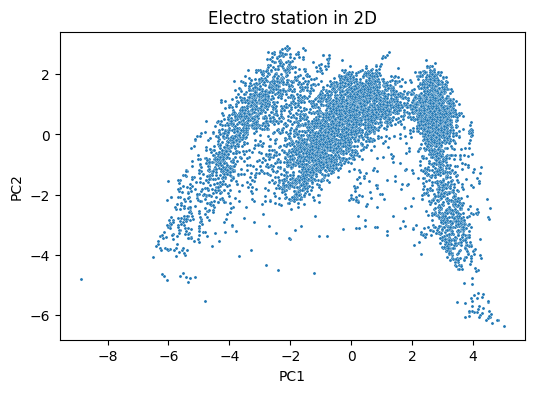

In [189]:
pca_2_df = PCA(n_components=2, random_state=42)
pca_2_df.fit(X_scaled)
X_pca2 = pd.DataFrame(pca_2_df.transform(X_scaled), columns=['PCA1','PCA2'])
plt.figure(figsize=(6, 4))
sns.scatterplot(x = X_pca2.iloc[:,0], y = X_pca2.iloc[:,1], palette="flare", s=5)
plt.title('Electro station in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

#   Можно предположить, что существует от 3-х до 5 кластеров. 

# Задание 3

Постройте модель кластеризации DBSCAN. Подберите оптимальные гиперпараметры, руководствуясь как результатами сеточного поиска, так и результатами анализа данных в предыдущих заданиях.

In [190]:
from sklearn.cluster import DBSCAN


In [227]:
# clustering_db = DBSCAN(eps=0.5, min_samples=10).fit(X)
dbscan_model = DBSCAN()
df_clusters_dbscan_deafult = pd.Series(dbscan_model.fit_predict(X_scaled))
print(f'Общее количество кластеров : {df_clusters_dbscan_deafult.nunique()}')
df_clusters_dbscan_deafult.value_counts().head()

# Видим, что количество кластеров велико, значительная часть наблюдений не была отнесена ни к одному кластеру.
# Требуется настройка гиперпараметров модели

Общее количество кластеров : 123


-1      2369
 4      1868
 70     1367
 53      240
 117     143
Name: count, dtype: int64

Для получения оптимальных гиперпараметров для алгоритма DBSCAN не применяют поиск по сетке и визуальный анализ.\
Воспользуется подходами, предложенными:
1. https://dzen.ru/a/YYgIiJsQx0aZjtzH?sid=161045125910742661
2. https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan  

И построим график

In [294]:
from sklearn.neighbors import NearestNeighbors
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(6,4))
    plt.plot(distances)
    plt.xlabel('Объекты в наборе данных', fontsize=12)
    plt.ylabel(f'Упорядоченная величина дистанции \nмежду {k} ближайшими соседями', fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.tight_layout()
    plt.show()    
    plt.close()


In [295]:
# Согласно [2] в качестве количества ближайших соседей целесообразно взять количество признаков датасета, уменьшенное на 1
k_nbrs = 2 * X_scaled.shape[-1] - 1 # k=2*{dim(dataset)} - 1

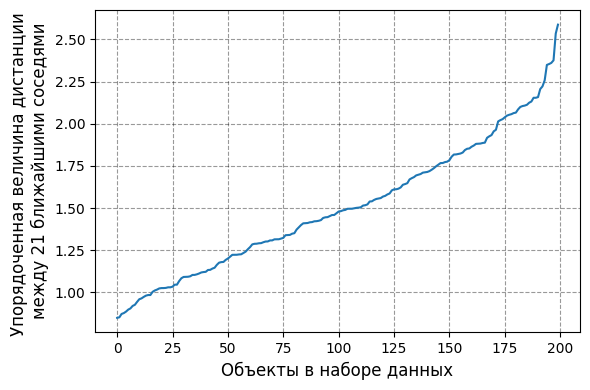

In [296]:
get_kdist_plot(X=X1_scaled, k=k_nbrs)
# Оптимальное значение параметра eps для алгоритма DBSCAN составляет 2,125

In [298]:
dbscan_model_opt = DBSCAN(eps=2.125, min_samples=k_nbrs, n_jobs=-1)
df_clusters_dbscan_deafult_opt = pd.Series(dbscan_model_opt.fit_predict(X_scaled))
print(f'Общее количество кластеров : {df_clusters_dbscan_deafult_opt.nunique()}')
df_clusters_dbscan_deafult_opt.value_counts().head()
# Фокус не удался, алгоритм объединил все объекты в один кластер.


Общее количество кластеров : 2


 0    7348
-1      36
Name: count, dtype: int64

In [324]:
# Все же придется воспользоваться поиском по сетке, в качестве граничных параметров используем параметры по умолчанию и параметры полученные по методике, использованной выше
# При этом воспользоваться готовым методом GridSearchCV не получится, т.к. для алгоритма DBSCAN нет встроенных метрик качества разделения на кластеры.
# Есть алгоритм, оценивающий эффективность, 
# https://stackoverflow.com/questions/33502455/best-way-to-validate-dbscan-clusters
# https://permetrics.readthedocs.io/en/latest/pages/clustering/DBCVI.html
# https://github.com/christopherjenness/DBCV
# но мы его не будем использовать т.к. он не входит в стандартную библиотеку sklearn

In [358]:
df_result = pd.DataFrame({'eps':[], 'min_samples':[], 'clusters_num':[], 'outliers_point_num':[], 'cluster_specifications':[]})
param_dict = {
    'eps':map(lambda x: round(x*0.1, 1), range(5,22,2)),
    'min_samples':range(5,k_nbrs+1,2)
}
for eps in param_dict['eps']:
    for min_samples in param_dict['min_samples']:
        dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        result = pd.Series(dbscan_model.fit_predict(X_scaled))
        # print(eps, min_samples, result.nunique())
        df_result.loc[len(df_result.index)] = [eps, min_samples, result.nunique(), result.value_counts().get(-1), result.value_counts().sort_index()[1:].to_dict()]
df_result
df_result.to_excel('./dscan_result.xlsx')



In [362]:
with option_context('display.max_colwidth', None):
    display(df_result.head(25))

eps  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            cluster_specifications
0   0.5  ...  {0: 13, 1: 6, 2: 13, 3: 6, 4: 1868, 5: 5, 6: 12, 7: 82, 8: 5, 9: 51, 10: 4, 11: 6, 12: 11, 13: 8, 14: 7, 15: 9, 16: 31, 17: 5, 18: 9, 19: 13, 20: 23, 21: 6, 22: 6, 23: 5, 24: 41, 25: 30, 26: 17, 27: 6, 28: 5, 29: 5, 30: 7, 31: 12, 32: 10, 33: 6, 34: 8, 35: 5, 36: 5, 37: 5, 38: 7, 39: 9, 40: 5, 41: 10, 42: 65, 43: 5, 44: 14, 45: 10, 46: 9, 47: 9, 48: 7, 49: 6, 50: 6, 51: 13, 52: 6, 53: 240, 54: 17, 55: 5, 56: 8, 57: 5, 58: 6, 59: 14, 60: 5, 61: 5, 62: 11, 63: 9, 64: 5, 65: 7, 66: 6, 67: 8, 68: 7, 69: 5, 70: 1367, 71: 11, 72: 5, 73: 7, 74: 22, 75: 7, 76: 4, 77: 11, 78: 10, 79: 5, 80: 5, 81: 8, 82: 9, 83: 4, 84: 16, 85: 9, 86: 7, 87: 14, 88: 6, 89: 7, 90: 6, 91: 16, 92: 17, 93: 26, 94: 7, 95: 7, 96: 15, 97: 26, 98: 9, 99: 6, ...}
1   0.5  ...                                                                                                                                                                             {0: 8, 1: 13, 2: 1723, 3: 8, 4: 11, 5: 77, 6: 33, 7: 11, 8: 8, 9: 13, 10: 4, 11: 9, 12: 23, 13: 7, 14: 35, 15: 6, 16: 29, 17: 7, 18: 17, 19: 7, 20: 9, 21: 12, 22: 9, 23: 7, 24: 7, 25: 7, 26: 10, 27: 60, 28: 14, 29: 8, 30: 7, 31: 7, 32: 7, 33: 8, 34: 178, 35: 8, 36: 10, 37: 7, 38: 7, 39: 9, 40: 7, 41: 10, 42: 7, 43: 18, 44: 7, 45: 11, 46: 8, 47: 1328, 48: 9, 49: 7, 50: 8, 51: 3, 52: 5, 53: 7, 54: 15, 55: 12, 56: 16, 57: 17, 58: 21, 59: 9, 60: 12, 61: 18, 62: 7, 63: 19, 64: 58, 65: 11, 66: 9, 67: 23, 68: 8, 69: 18, 70: 44, 71: 7, 72: 141, 73: 10, 74: 11, 75: 7}
2   0.5  ...                                                                                                                                                                                                                                                                                                                                                                                                                                         {0: 12, 1: 167, 2: 77, 3: 31, 4: 9, 5: 13, 6: 16, 7: 29, 8: 29, 9: 10, 10: 12, 11: 26, 12: 8, 13: 20, 14: 32, 15: 14, 16: 14, 17: 167, 18: 1338, 19: 11, 20: 1284, 21: 14, 22: 11, 23: 14, 24: 10, 25: 14, 26: 13, 27: 19, 28: 9, 29: 12, 30: 9, 31: 19, 32: 51, 33: 20, 34: 23, 35: 19, 36: 91, 37: 42, 38: 135, 39: 11}
3   0.5  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              {0: 139, 1: 77, 2: 31, 3: 11, 4: 16, 5: 17, 6: 26, 7: 24, 8: 17, 9: 29, 10: 13, 11: 162, 12: 1208, 13: 17, 14: 1231, 15: 11, 16: 10, 17: 12, 18: 11, 19: 14, 20: 9, 21: 18, 22: 49, 23: 23, 24: 17, 25: 88, 26: 38, 27: 16, 28: 122}
4   0.5  ...                                                                                                                                                                                                                                             

In [364]:
# Наиболее интересными результами можно признать результаты по критериям:
#  а. Разумное количество кластеров;
#  б. Наименьшее количество наблюдений, отнесенных к выбросам;
#  в. равномерное распределение наблюдений между кластерами.
with option_context('display.max_colwidth', None):
    display(df_result.loc[[9, 13, 18]])


eps  ...                                                                                                                                                                                                                                                                                                                                          cluster_specifications
9   0.7  ...  {0: 5699, 1: 269, 2: 13, 3: 12, 4: 6, 5: 7, 6: 22, 7: 5, 8: 28, 9: 39, 10: 6, 11: 6, 12: 5, 13: 5, 14: 5, 15: 5, 16: 15, 17: 22, 18: 6, 19: 12, 20: 9, 21: 5, 22: 5, 23: 17, 24: 8, 25: 5, 26: 5, 27: 5, 28: 5, 29: 5, 30: 10, 31: 26, 32: 6, 33: 6, 34: 10, 35: 8, 36: 17, 37: 6, 38: 5, 39: 30, 40: 11, 41: 12, 42: 11, 43: 13, 44: 8, 45: 9, 46: 7, 47: 23}
13  0.7  ...                                                                                                                                                                                                              {0: 13, 1: 17, 2: 4754, 3: 13, 4: 187, 5: 13, 6: 19, 7: 43, 8: 47, 9: 16, 10: 18, 11: 14, 12: 15, 13: 74, 14: 16, 15: 27, 16: 28, 17: 157, 18: 18}
18  0.9  ...                                                                                                                                                                                                             {0: 6770, 1: 36, 2: 6, 3: 5, 4: 4, 5: 5, 6: 14, 7: 6, 8: 5, 9: 5, 10: 5, 11: 5, 12: 7, 13: 14, 14: 5, 15: 52, 16: 18, 17: 23, 18: 8, 19: 5, 20: 24}

[3 rows x 5 columns]

In [260]:
Похоже, что алгоритм основанный на плотности не очень хорошо разделил данные.
Получается либо один большой кластер, либо большое количество выборосов, либо много кластеров, либо сочетание вышеперечисленного.
Нет результата с небольшим количеством кластеров, равномерного распределения наблюдений по кластерам и небольшого количества выбросов.
Либо нужно пробовать работать с признаками, добиваясь разделимости кластеров, либо пробовать другую модель.

0.7

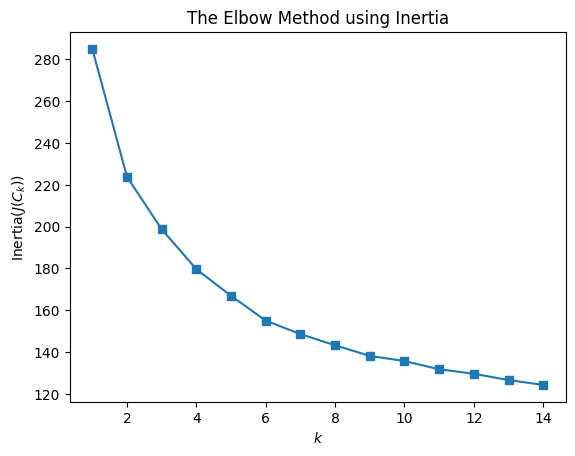

In [365]:
# Попробуем KNN
inertias = []
distortions = []
max_clusters = 15

for k in range(1, max_clusters):
    model_kmeans = KMeans(n_clusters=k, random_state=40, n_init='auto').fit(X_scaled)
    inertias.append(np.sqrt(model_kmeans.inertia_))
    # distortions.append(sum(np.min(cdist(X, model_kmeans.cluster_centers_,
    #                                     'euclidean'), axis=1)) / X.shape[0])

plt.plot(range(1, max_clusters), inertias, marker="s")
plt.title('The Elbow Method using Inertia')
plt.xlabel("$k$")
plt.ylabel("Inertia($J(C_k)$)");

# Резкого перегиба не набюдается.

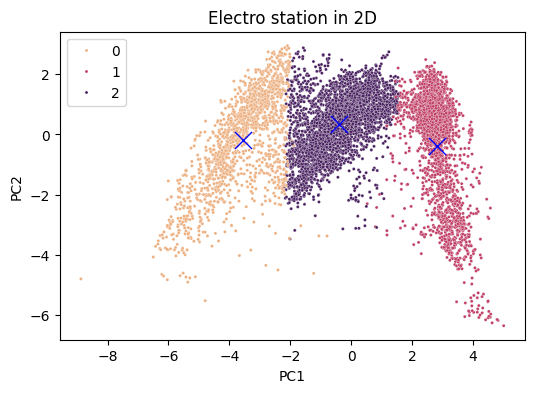

In [375]:
# Попробуем использовать количество кластеров 3, как видно на визуализации 
model_knn_for_station = KMeans(n_clusters=3, random_state=40, n_init='auto')
model_knn_for_station.fit_predict(X_scaled)
station_labels = model_knn_for_station.labels_
df_centroids_pca = pca_2_df.transform(model_knn_for_station.cluster_centers_)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca2.iloc[:,0], y=X_pca2.iloc[:,1], hue=model_knn_for_station.labels_,  palette="flare", s=5)
sns.scatterplot(x=df_centroids_pca[:, 0], y=df_centroids_pca[:, 1], marker="x", s=150, color = 'blue')
plt.title('Electro station in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Видим отличный результат.

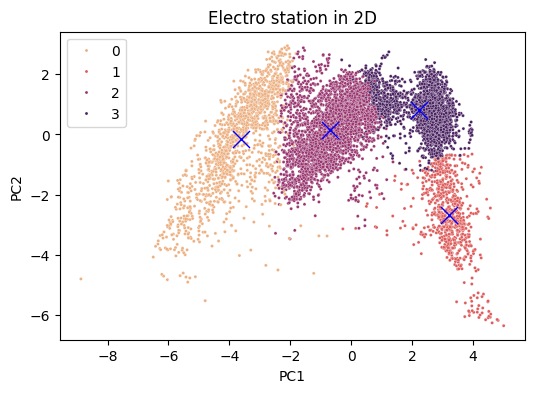

In [370]:
# Попробуем использовать количество кластеров 4
model_knn_for_station = KMeans(n_clusters=4, random_state=40, n_init='auto')
model_knn_for_station.fit_predict(X_scaled)
df_centroids_pca = pca_2_df.transform(model_knn_for_station.cluster_centers_)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca2.iloc[:,0], y=X_pca2.iloc[:,1], hue=model_knn_for_station.labels_,  palette="flare", s=5)
sns.scatterplot(x=df_centroids_pca[:, 0], y=df_centroids_pca[:, 1], marker="x", s=150, color = 'blue')
plt.title('Electro station in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Неплохо, но не очень очевидно.

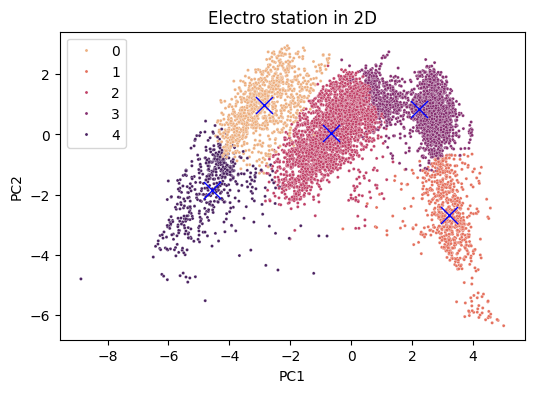

In [372]:
# Попробуем использовать количество кластеров 5
model_knn_for_station = KMeans(n_clusters=5, random_state=40, n_init='auto')
model_knn_for_station.fit_predict(X_scaled)
df_centroids_pca = pca_2_df.transform(model_knn_for_station.cluster_centers_)

plt.figure(figsize=(6, 4))
sns.scatterplot(x=X_pca2.iloc[:,0], y=X_pca2.iloc[:,1], hue=model_knn_for_station.labels_,  palette="flare", s=5)
sns.scatterplot(x=df_centroids_pca[:, 0], y=df_centroids_pca[:, 1], marker="x", s=150, color = 'blue')
plt.title('Electro station in 2D')
plt.xlabel('PC1')
plt.ylabel('PC2');

# Если пытаться визуально выделить кластеры после снижения размерности модели до 2-х признаков, то результат с количеством кластеров равным 3 можно считать наилучшим.

# Задание 4

Интерпретируйте результаты кластеризации: объясните, чем схожи электростанции в каждом кластере и чем аномальные электростанции отличаются от остальных.

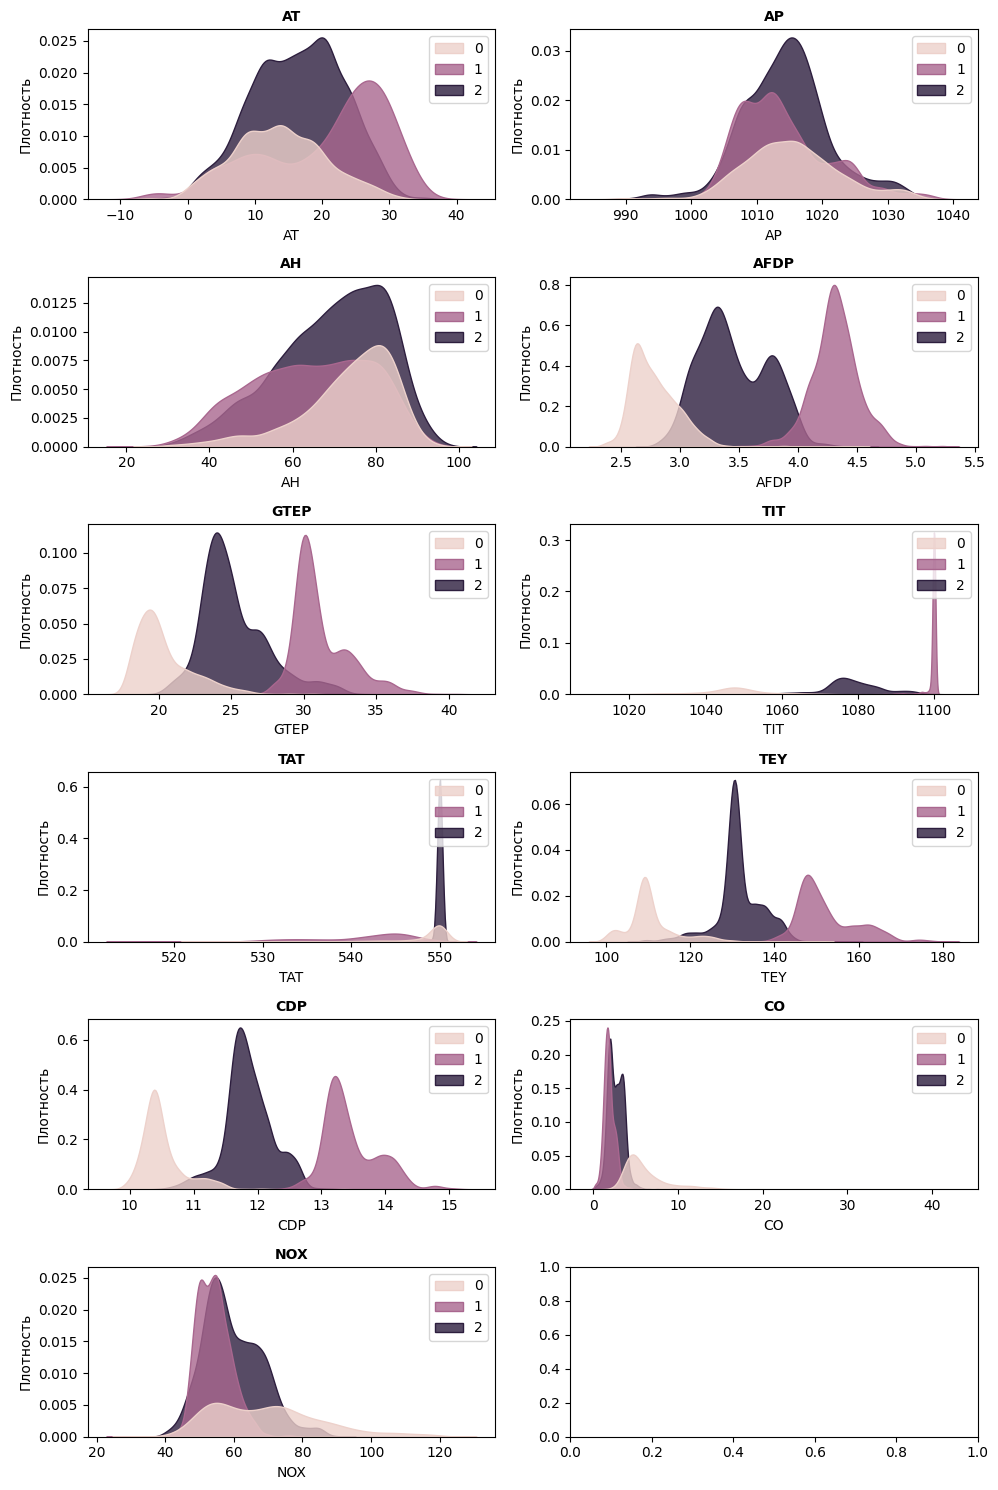

In [382]:
# Создаем матрицу графиков для визуализации распредления по каждой переменной
fig, axes = plt.subplots(6,2, figsize = (10,15))

# Расстояние между графиками
plt.subplots_adjust(hspace=0.5)

# Список значений признаков для цикла
columns = df.columns

# Строим распределения (kdeplot) для каждого признака
for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    sns.kdeplot(data = df,
                x = column,
                fill = True,
                alpha = 0.8,
                hue = station_labels,
                ax = ax)

    ax.set_title(column, fontweight = 'bold', fontsize = 10)
    ax.set_xlabel(column, fontsize = 10)
    ax.set_ylabel('Плотность', fontsize = 10)

plt.tight_layout()
plt.show()

На графиках наблюдаем, что наблюдения разделелись по признакам:
 - AT	температура окружающей среды
 - AFDP	перепад давления на воздушном фильтре
 - GTEP	давление на выходе из газовой турбины
 - TIT	температура на входе в турбину
 - TEY	энергоотдача турбины
 - CDP	давление нагнетания компрессора
 - CO	выбросы угарного газа (разделение есть, заметно на логарифмической шкале по причине наличия выбросов)

Можно сказать, что основной признак это энергоотдача турбины.

Можно попробовать сделать более далеко идущие выводы, что это разные поколения станций, построенных в разное время по разным технологиям.

Этим же можно объяснить то, почему алгоритм DBSCAN не показал себя на этой задаче.\
Т.к. это разные поколения станций то дело не в плотности наблюдений, а в их разделени в пространстве признаков.

<AxesSubplot: xlabel='CO', ylabel='Density'>

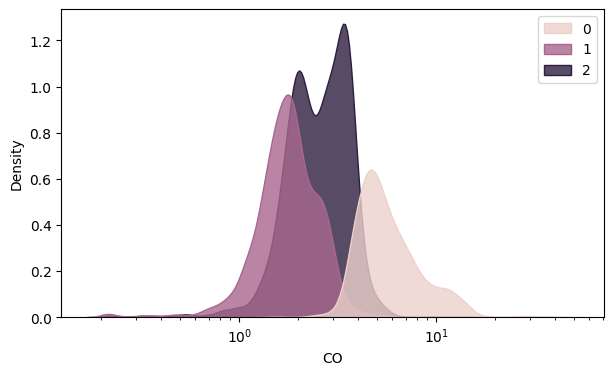

In [402]:
plt.figure(figsize = (7,4))
sns.kdeplot(data = df, x = 'CO', fill = True, alpha = 0.8, hue = station_labels, log_scale=True)